In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

In [8]:
def _get_metrics_from_tensorboard(event_acc, scalar):
    train_metrics, val_metrics = event_acc.Scalars(f'{scalar}/train'), event_acc.Scalars(f'{scalar}/valid')
    train_df, val_df = pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)

    train_df.drop(columns=['wall_time'], inplace=True)
    val_df.drop(columns=['wall_time'], inplace=True)

    train_df.rename(columns={'value': f'train_{scalar}'}, inplace=True)
    val_df.rename(columns={'value': f'val_{scalar}'}, inplace=True)
    results = pd.merge(train_df, val_df, on='step', how='outer')
    results = results.dropna()
    results = results.drop(columns=['step'])
    return results


def tensorboard_results(log_dir, experiment_name):
    events = EventAccumulator(log_dir)
    events.Reload()

    print(events)
    loss, acc, prec, rec = (
        _get_metrics_from_tensorboard(events, 'loss_e'),
        _get_metrics_from_tensorboard(events, 'acc'),
        _get_metrics_from_tensorboard(events, 'prec'),
        _get_metrics_from_tensorboard(events, 'rec')
    )

    result_keys = {
        'BCE Loss': loss,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    fig.suptitle(f'Loss, Accuracy, Precision, Recall for {experiment_name}', fontsize=16)



    results_matrix = pd.concat([loss, acc, prec, rec], axis=1)
    for i, (key, value) in enumerate(result_keys.items()):
        fig_ = sns.lineplot(value, ax=axes[i])
        fig_.set(xlabel='Epoch', ylabel=key, title=key)
    return results_matrix

def top_metrics(results):
    metric_container = []
    for experiment_name, df in results.items():
        metric_container.append(_best_metrics(df, experiment_name))
    
    return pd.DataFrame(metric_container)

def _best_metrics(df, name):

    # last row from columns
    return {
        'Experiment': name,
        'BCE Loss': df['val_loss_e'].iloc[-1].round(4),
        'Accuracy': df['val_acc'].iloc[-1].round(4),
        'Precision': df['val_prec'].iloc[-1].round(4),
        'Recall': df['val_rec'].iloc[-1].round(4),
    }


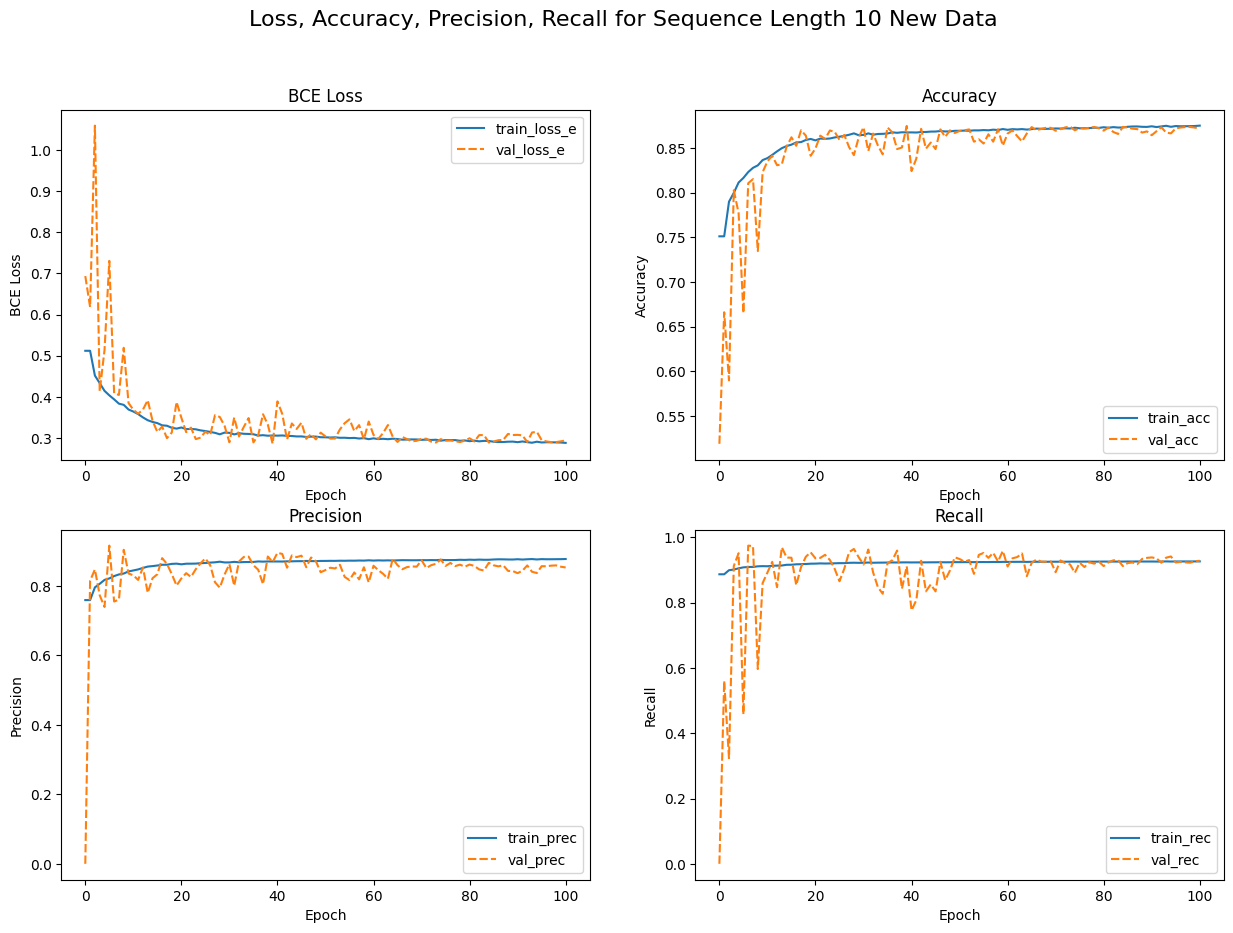

In [9]:
log_seq_dir_10 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_10/data_partition_None/2023_03_30_07_54/version_0'

seq_10 = tensorboard_results(log_seq_dir_10, 'Sequence Length 10 New Data')

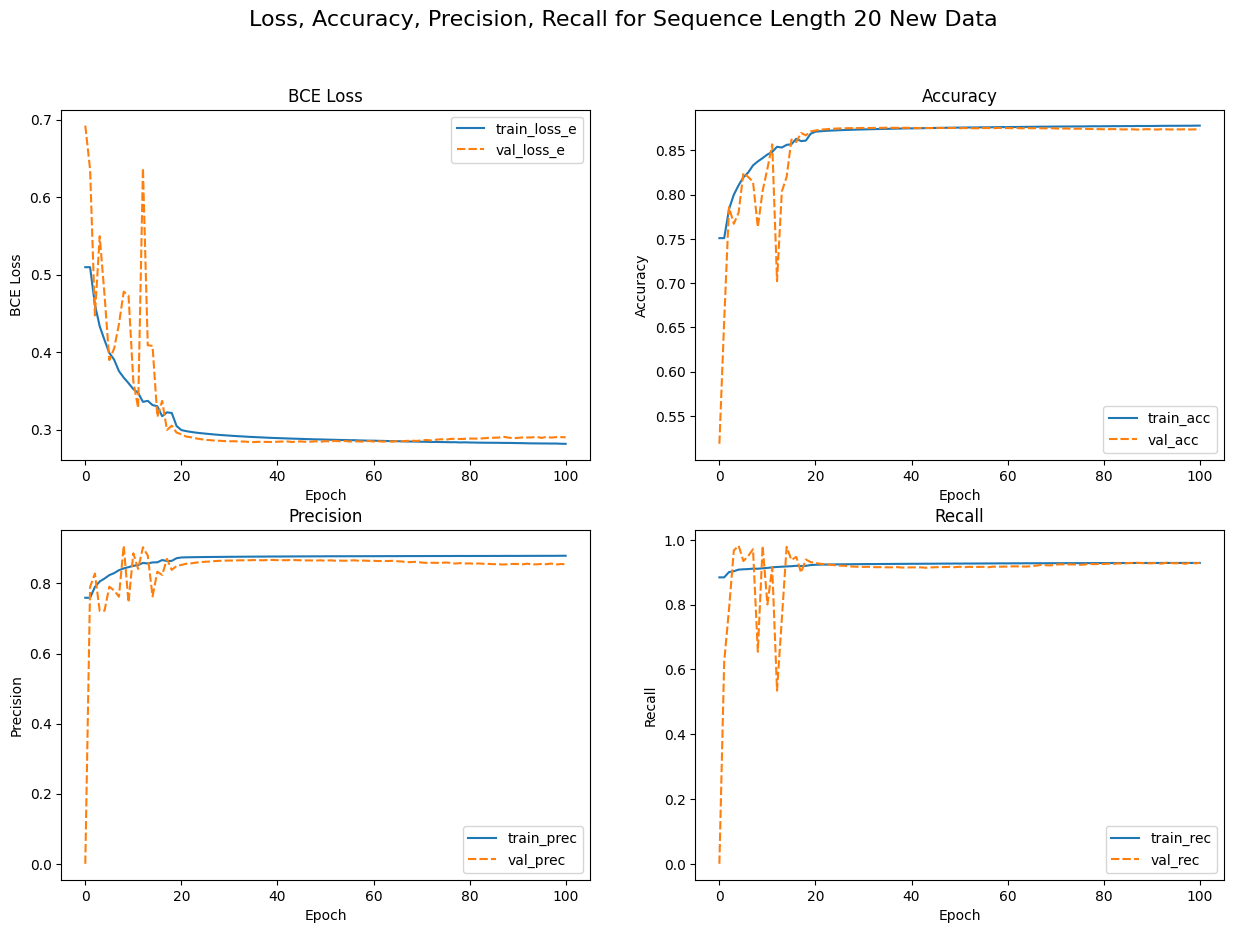

In [10]:
log_seq_dir_20 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_20/data_partition_None/2023_04_04_11_24/version_0'
seq_20 = tensorboard_results(log_seq_dir_20, 'Sequence Length 20 New Data')

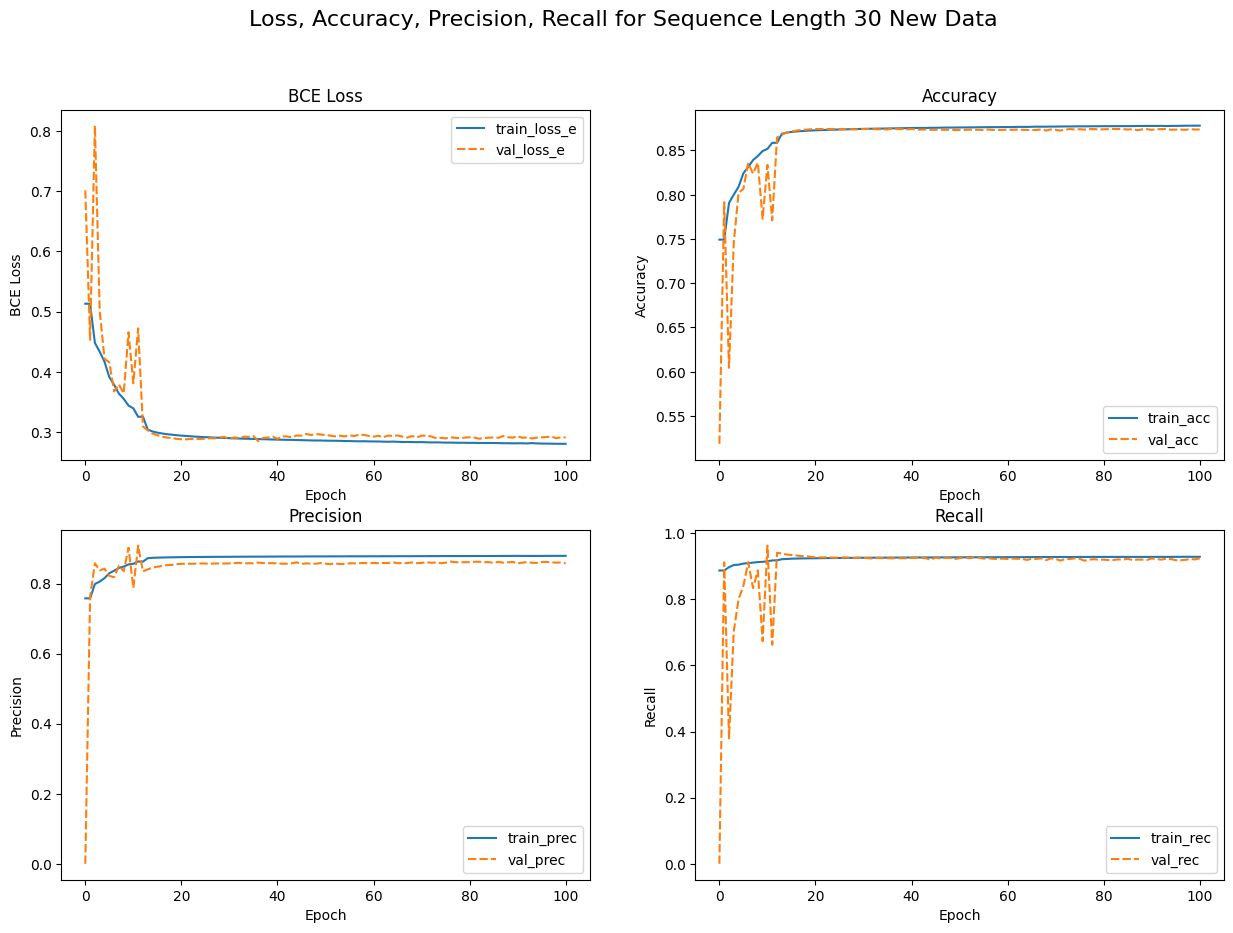

In [11]:
log_dir_seq_30 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_30/data_partition_None/2023_04_05_07_59/version_0/'
seq_30 = tensorboard_results(log_dir_seq_30, 'Sequence Length 30 New Data')

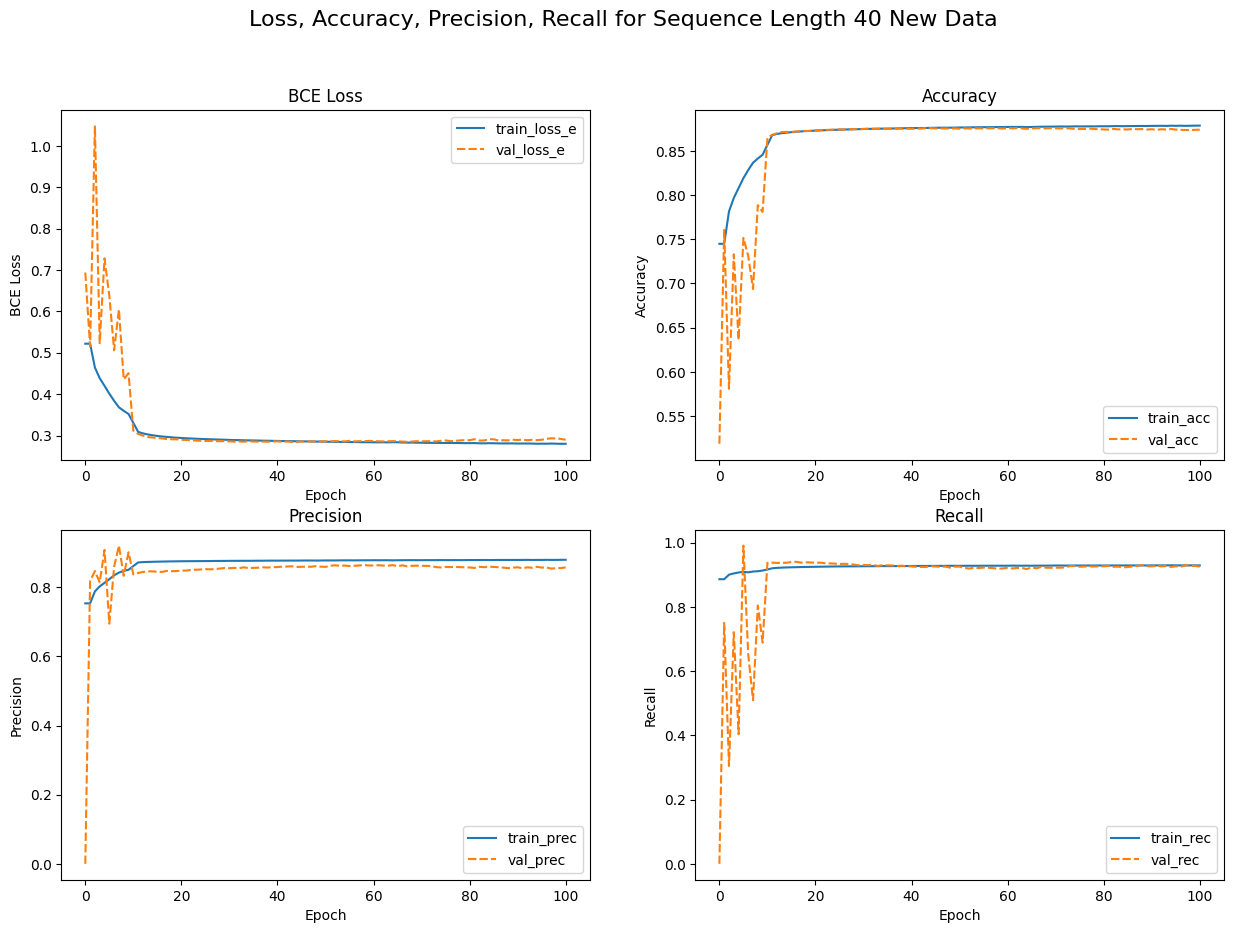

In [12]:
log_dir_seq_40 = 's3://dissertation-data-dmiller/lstm_experiments/results/data_v1/n_files_30/ordinal/sequence_length_40/data_partition_None/2023_04_06_07_51/version_0'

seq_40 = tensorboard_results(log_dir_seq_40, 'Sequence Length 40 New Data')

In [13]:
metrics = top_metrics(
    {'seq_10_results': seq_10, 
     'seq_20_results': seq_20,
     'seq_30_results': seq_30,
     'seq_40_results': seq_40})

In [14]:
metrics

,Experiment,BCE Loss,Accuracy,Precision,Recall
0,seq_10_results,0.2939,0.8720,0.8526,0.9282
1,seq_20_results,0.2901,0.8736,0.8547,0.9285
2,seq_30_results,0.2915,0.8737,0.8580,0.9240
3,seq_40_results,0.2897,0.8740,0.8576,0.9252
